# <span style="color:#84b6f4;">Detección de humanos</span>

### <span style="color:#77dd77;">Formación del DataFrame</span>

En este ejemplo, trataremos de detectar la presencia de seres humanos en imágenes. Comenzamos creando el DataFrame con una serie de imágenes que se han recopilado, etiquetando como 1 las imágenes en las que aparecen seres humanos y como 0 las imágenes en las que no aparecen:

In [40]:
import pandas as pd
import os
import random

human_directory = os.getcwd() + '/resources/humanImages'
not_human_directory = os.getcwd() + '/resources/notHumanImages'

data = []

# Etiquetamos como 1 las imágenes en las que aparecen seres humanos
for image in os.listdir(human_directory):
    image_url = os.path.join(human_directory, image)
    data.append({"image": image_url, "label": 1})

# Etiquetamos como 0 las imágenes en las que no aparecen seres humanos
count = 0
for image in os.listdir(not_human_directory):
    ruta_imagen = os.path.join(not_human_directory, image)
    data.append({"image": ruta_imagen, "label": 0})
    count += 1

# Desordenamos aleatoriamente los datos
random.shuffle(data)

# Creamos el DataFrame
df = pd.DataFrame(data)

Mostramos las 10 primeras imágenes, en escala de grises y tras haber sido preprocesadas:

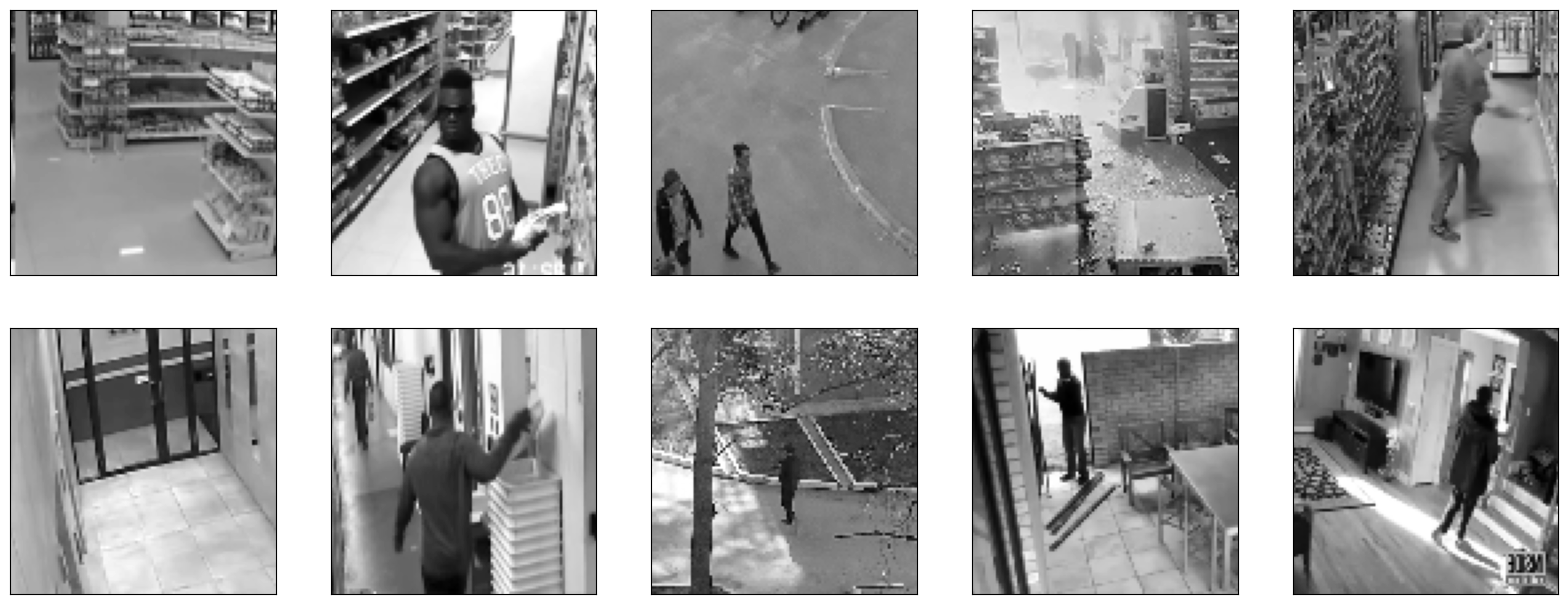

In [41]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20, 20))

IMG_SIZE = 100

# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(url):
    image = cv2.imread(url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

# Mostramos las 10 primeras imágenes
for i, row in df.head(10).iterrows():
    image_url = row['image']
    image = load_and_preprocess_image(image_url)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap='gray')

Cargamos las imágenes de entrada (los píxeles) y las etiquetas asociadas a cada imagen:

In [42]:
import numpy as np

images = []
labels = []

# Cargamos las imágenes y etiquetas asociadas del DataFrame en "images" y "labels"
for i, row in df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    images.append(image)
    labels.append(row['label'])

images = np.array(images).astype(float) / 255
labels = np.array(labels)

### <span style="color:#77dd77;">Aumento de datos</span>

Aplicamos transformaciones de aumento de datos a las imágenes, para volver el conjunto de datos más diverso:

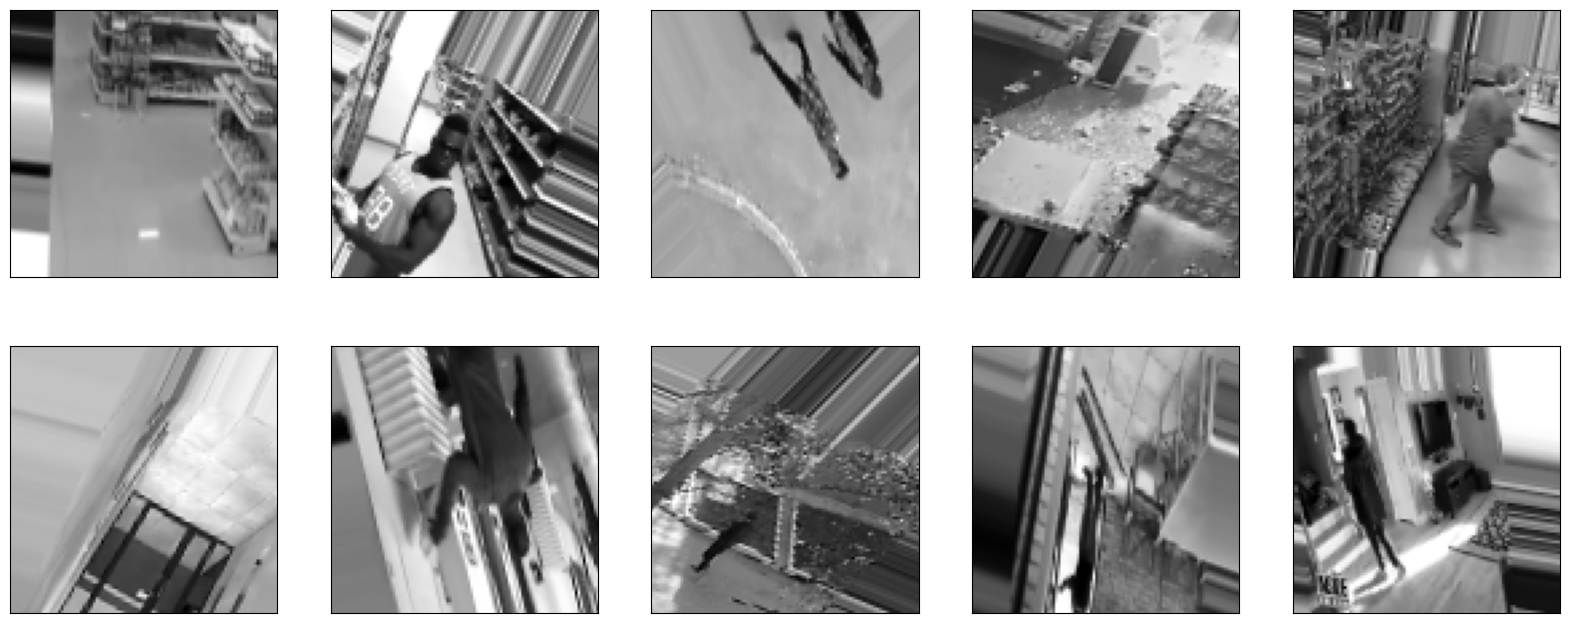

In [43]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Creamos un generador de imágenes aumentadas
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajustamos el generador al conjunto de imágenes original
datagen.fit(images)

plt.figure(figsize=(20,8))

# Obtenemos un lote de imágenes aumentadas
for image, label in datagen.flow(images, labels, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    break  # Rompemos el bucle después de mostrar un lote

Generamos más imágenes, para mejorar los resultados:

In [50]:
import numpy as np

# Separa las imágenes en dos grupos
images_human = images[labels == 1]
images_not_human = images[labels == 0]
labels_human = labels[labels == 1]
labels_not_human = labels[labels == 0]

# Determina cuántas imágenes necesitas generar
num_required = 200

# Función para aumentar un conjunto de imágenes y etiquetas
def augment_images(images, num_required, datagen):
    num_transformations_per_image = np.ceil((num_required) / len(images)).astype(int)
    augmented_images = []
    for x in images:
        for _ in range(num_transformations_per_image):
            for image_batch in datagen.flow(x[None], batch_size=1):
                augmented_images.append(image_batch[0])
                break
        if len(augmented_images) >= num_required:
            break
    return np.array(augmented_images)

# Aplica el aumento a cada grupo
augmented_images_not_human = augment_images(images_not_human, num_required, datagen)

# Combina los grupos en un solo conjunto
final_images_not_human = np.concatenate((images_not_human, augmented_images_not_human), axis=0)
final_labels_not_human = np.zeros(len(final_images_not_human))

final_images = np.concatenate((images_human, final_images_not_human), axis=0)
final_labels = np.concatenate((labels_human, final_labels_not_human), axis=0)

print(len(final_images))

1119


### <span style="color:#77dd77;">Entrenamiento</span>

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos:

In [45]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.3, random_state=42)

# Creamos el modelo CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuramos el modelo para el entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=100, batch_size=32,
    validation_data=(test_images, test_labels),
    steps_per_epoch=int(np.ceil(len(train_images) / float(32))),
    validation_steps=int(np.ceil(len(test_images) / float(32)))
)

Epoch 1/100
25/25 [==============================] - 6s 193ms/step - loss: 0.7017 - accuracy: 0.4955 - val_loss: 0.6962 - val_accuracy: 0.4524
Epoch 2/100
25/25 [==============================] - 5s 183ms/step - loss: 0.6931 - accuracy: 0.5262 - val_loss: 0.6962 - val_accuracy: 0.4524
Epoch 3/100
25/25 [==============================] - 4s 174ms/step - loss: 0.6913 - accuracy: 0.5300 - val_loss: 0.7166 - val_accuracy: 0.4524
Epoch 4/100
25/25 [==============================] - 4s 175ms/step - loss: 0.6866 - accuracy: 0.5504 - val_loss: 0.6837 - val_accuracy: 0.4792
Epoch 5/100
25/25 [==============================] - 4s 174ms/step - loss: 0.6778 - accuracy: 0.5607 - val_loss: 0.6564 - val_accuracy: 0.6310
Epoch 6/100
25/25 [==============================] - 4s 173ms/step - loss: 0.6823 - accuracy: 0.5364 - val_loss: 0.6616 - val_accuracy: 0.5804
Epoch 7/100
25/25 [==============================] - 5s 182ms/step - loss: 0.6874 - accuracy: 0.5683 - val_loss: 0.6426 - val_accuracy: 0.6964

### <span style="color:#77dd77;">Evaluación</span>

Evaluamos los resultados del modelo, utilizando métricas como la precisión, el F1-score y la matriz de confusión:

In [46]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Realizamos las predicciones con los datos de prueba
test_predictions = model.predict(test_images)
test_predictions_rounded = np.round(test_predictions)

# Evaluamos el modelo con diferentes métricas
accuracy = accuracy_score(test_labels, test_predictions_rounded)
f1 = f1_score(test_labels, test_predictions_rounded)
confusion = confusion_matrix(test_labels, test_predictions_rounded)

# Mostramos los resultados
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(confusion)

11/11 [==============================] - 0s 32ms/step
Accuracy: 0.7083333333333334
F1 Score: 0.7710280373831776
[[ 73  79]
 [ 19 165]]


Para finalizar, exportamos el modelo:

In [47]:
from joblib import dump

# Guardamos el modelo
model_filename = 'human_detection.joblib'
dump(model, model_filename)

['human_detection.joblib']